Using the dataset for handwritten alphabet characters found at here: https://www.kaggle.com/datasets/riseofphoenix/handwritten-alphabetshttps://www.kaggle.com/datasets/riseofphoenix/handwritten-alphabets

# **Task 1**

**Part 1**

I am using a handwritten dataset consisting of alphabet characters. They will be divided into 26 categories for each of the letters in the dataset. Each of the image data is in 28 by 28 pixel form.


In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import PIL.Image as Image
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import matplotlib.pyplot as plt
import os
import gc

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") #We will be using a gpu to speed up our process if its available

In [8]:
path = Path("/kaggle/input/az-handwritten-alphabets-in-csv-format") # Path to our dataset

In [9]:
df = pd.read_csv('/kaggle/input/handwritten-alphabets/Handwritten Alphabets Data.csv')
df

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372445,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
372446,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
372447,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
372448,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The first column is the label for the row. '0' represents 'A' and '25' represents 'Z' and such. Let us change the data around and see how much we have of each data.

In [10]:
df['0'] = [ chr(i+ord('A')) for i in  df['0']]

In [11]:
df['0'].value_counts()

0
O    57825
S    48419
U    29008
C    23409
T    22495
P    19341
N    19010
A    13869
M    12336
L    11586
R    11566
E    11440
Y    10859
W    10784
D    10134
B     8668
J     8493
H     7218
X     6272
Z     6076
Q     5812
G     5762
K     5603
V     4182
F     1163
I     1120
Name: count, dtype: int64

We have a rather big disparity in our data with lots of data values for the character 'O' but not much for 'I.' We will have to take that into consideration while splitting into our train test val sets.

Let's try viewing our data

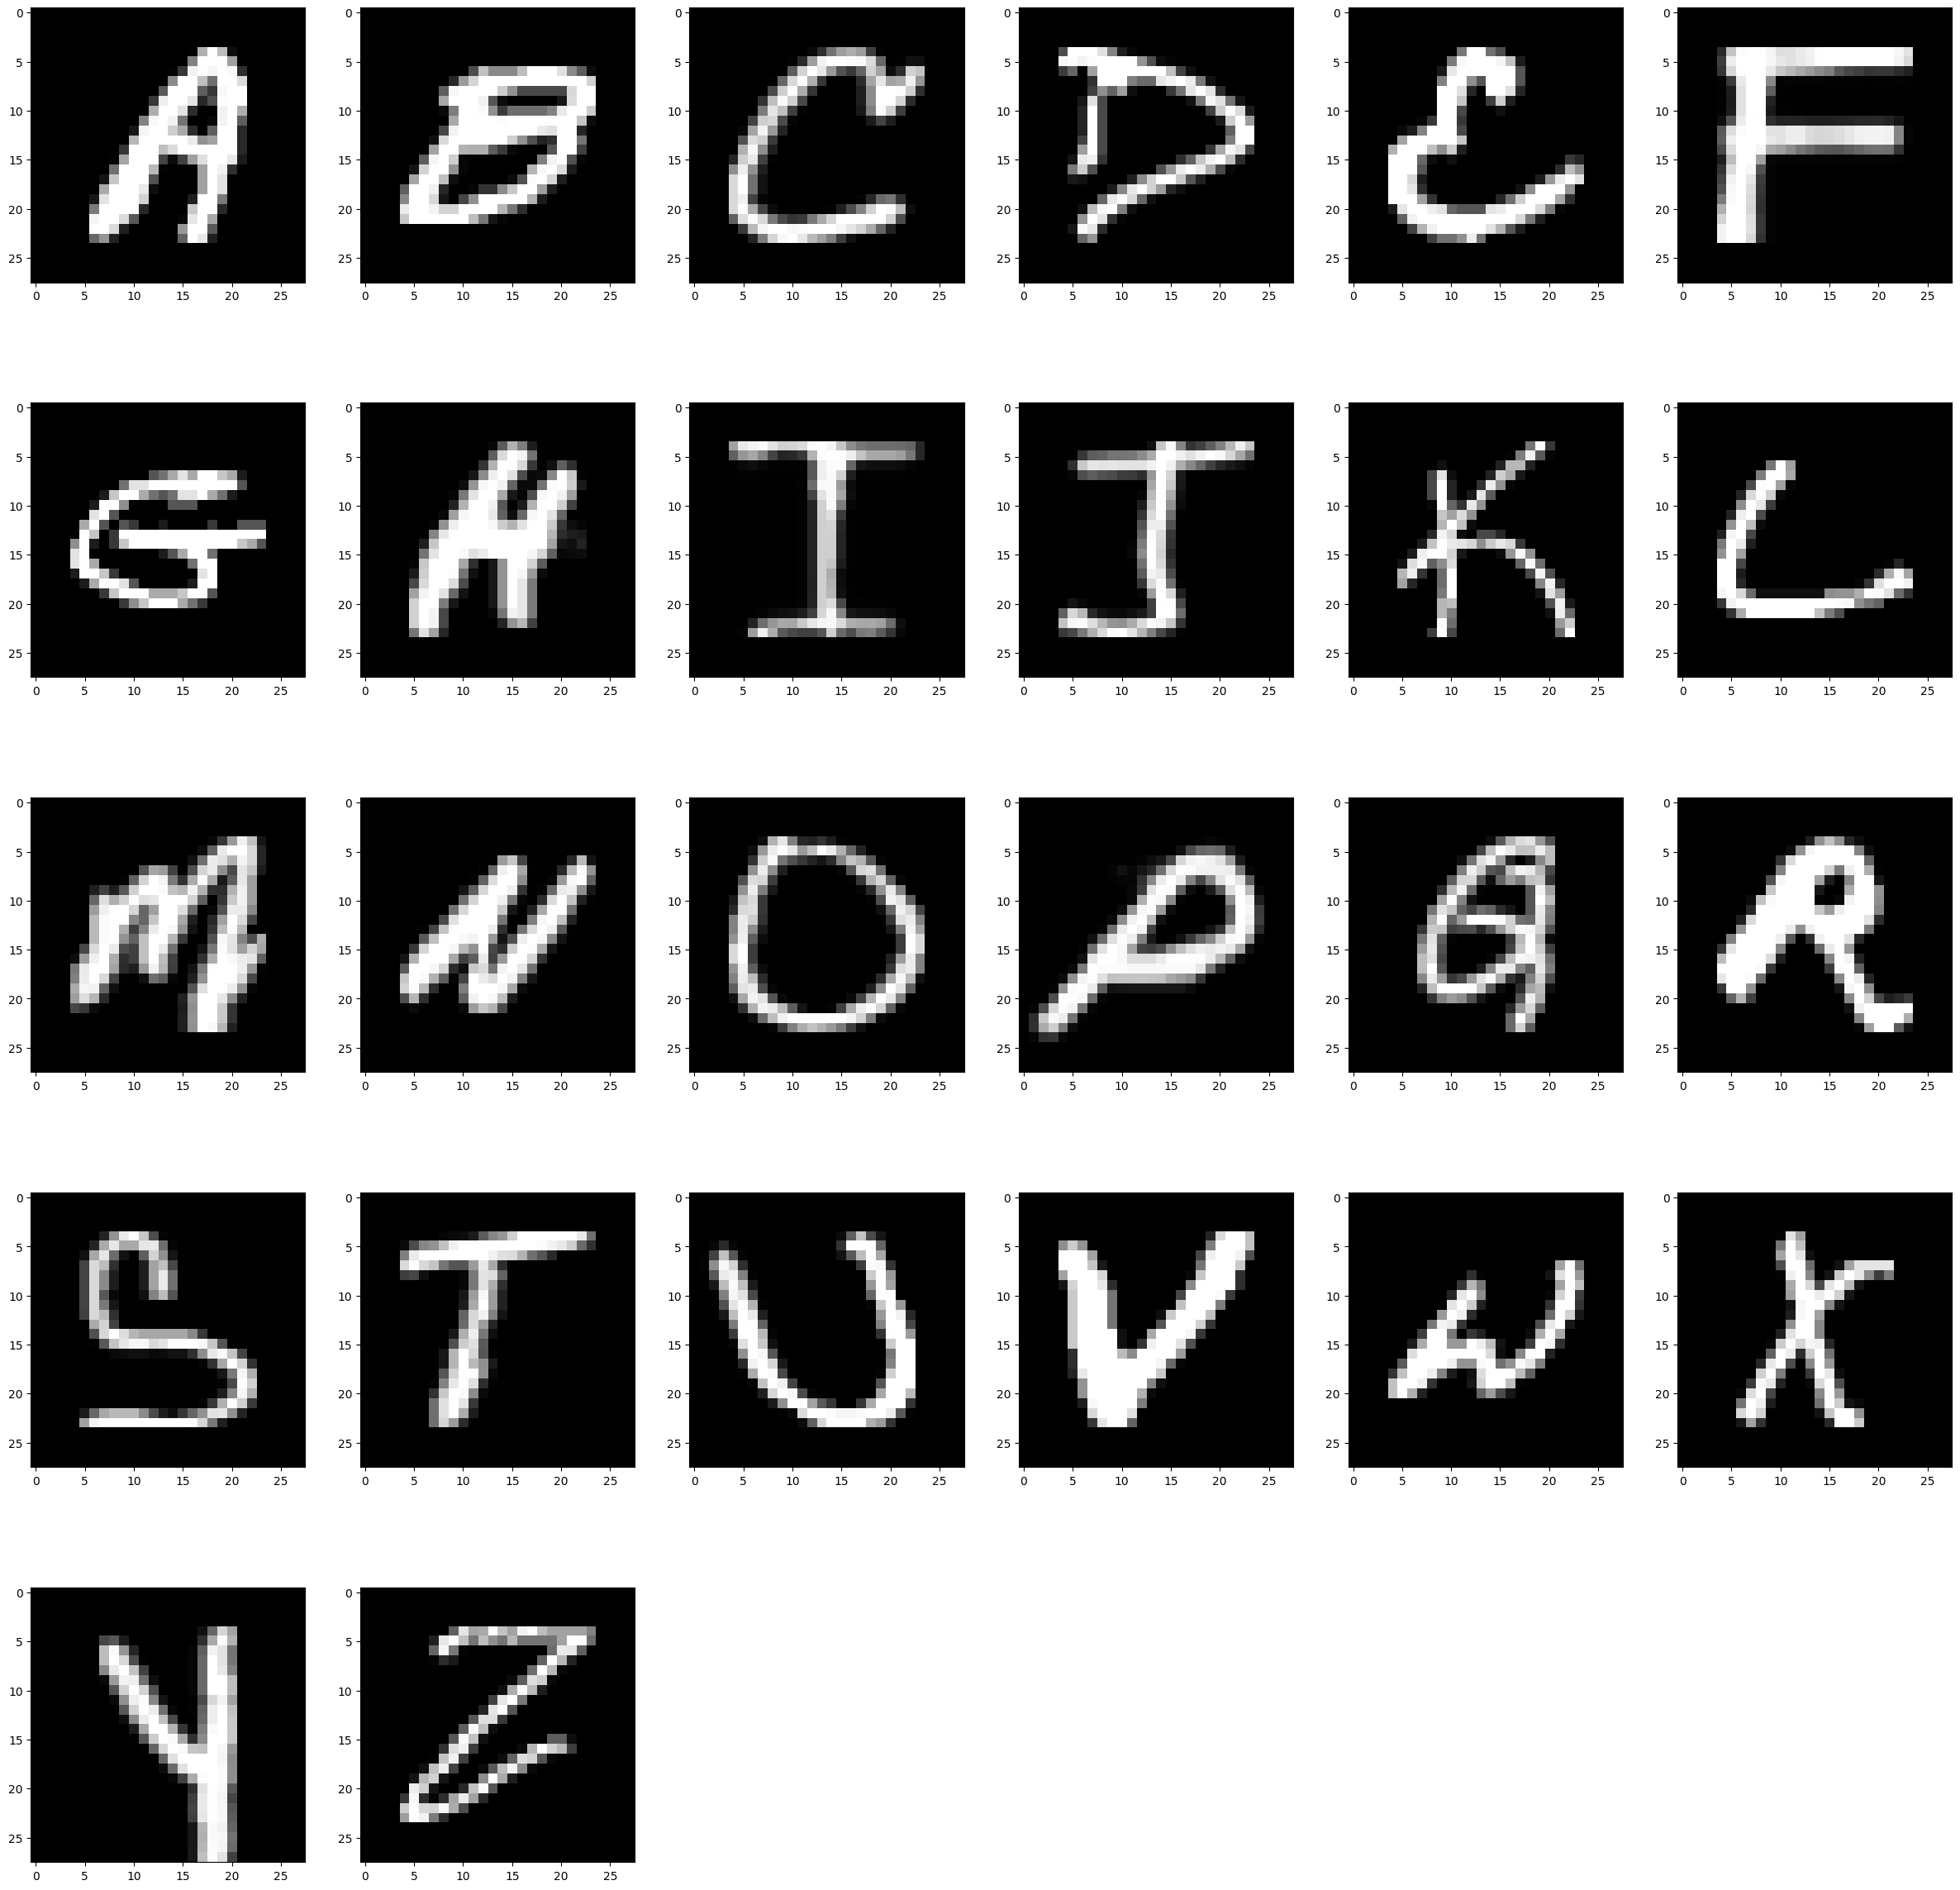

In [12]:
plt.figure(figsize=(30, 30))

i = 0
for idx in range(len(df)):
    if(df['0'][idx] == chr(i+ord('A'))):
        plt.subplot(5,6,i+1), plt.imshow(np.array(df.iloc[idx][1:], dtype=int).reshape(28, 28), cmap = 'gray')
        i += 1

plt.show()

Our alphabet dataset has pictures of pretty good pictures of the writing in a recognizable form.

Now, let's make our dataset.

In [13]:
def tensorify(a):
    return torch.FloatTensor(a)

In [14]:
train_set, val_set, test_set = [], [], []
for character in tqdm(range(26)):
    arr = np.array(df[df['0'] == chr(character+ord('A'))])[:,1:] # getting only what corresponds to our letter
    random.shuffle(arr)     # Shuffling our dataset to ensure that our model will work under random circumstance
    arr = arr/256           # We want our data to be between 0 and 1
    arr = arr.reshape(-1, 1, 28, 28) # Putting it in (x, 1, 28, 28) form to allow for filtering in convolutions
    
    a = [0]*26
    a[character] = 1        # one hot encoding of data

    # Let's split each part set into 60 - 20 - 20 sets for our train, val, and test set
    train_set.extend([ (tensorify(dt.astype(float)), tensorify(a)) for dt in arr[: int(0.6*len(arr))]] )
    val_set.extend(  [ (tensorify(dt.astype(float)), tensorify(a)) for dt in arr[int(0.6*len(arr)) : int(0.8*len(arr))]] )
    test_set.extend( [ (tensorify(dt.astype(float)), tensorify(a)) for dt in arr[int(0.8*len(arr)) :]] )

100%|██████████| 26/26 [01:45<00:00,  4.07s/it]


In [15]:
random.shuffle(train_set)    # Basic shuffling to ensure randomness and that the data isn't fed from A to Z in order
random.shuffle(val_set)
random.shuffle(test_set)

Let's check our set sizes

In [16]:
len(train_set), len(val_set), len(test_set)

(223459, 74491, 74500)

In [17]:
train_set[0][0].shape

torch.Size([1, 28, 28])

In [18]:
train_set[0][1]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

Our data looks good. Now, we make it into a dataloader to speed up the learning process.

In [19]:
train_dataloader = DataLoader(dataset = train_set, batch_size = 64, num_workers = 2)
val_dataloader = DataLoader(dataset = val_set, batch_size = 64, num_workers = 2)
test_dataloader = DataLoader(dataset = test_set, batch_size = 64, num_workers = 2)

Now let's build our model. We will stack 2 Conv layers and 2 Pooling Layers before using dense linear layers. The idea is to use the Conv layers to pick up on overlying patterns at the top and use the dense layers to quickly come to a conclusion.

In [20]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_layer = nn.Sequential(*[                                          #input size =  [64, 1, 28, 28]
            nn.Conv2d(1, 16, kernel_size = 3, stride = 1, padding = 1),             #output size = [64, 16, 28, 28]
            nn.MaxPool2d(2),                                                        #output size = [64, 16, 14, 14]
            nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1),            #output size = [64, 32, 14, 14]
            nn.MaxPool2d(2),                                                        #output size = [64, 32, 7, 7]
        ])
        
        self.dense = nn.Sequential(*[                                               #input size =  [64, 32, 49]
            nn.Linear(49, 16),                                                      #output size = [64, 32, 16]
        ])
        
        self.fc = nn.Sequential(*[                                                  #input size =  [64, 512]
            nn.LayerNorm(512),                                                      #output size = [64, 512]
            nn.Linear(512, 64),                                                     #output size = [64, 64]
            nn.ReLU(),                                                              #output size = [64, 64]
            nn.Linear(64, 26),                                                      #output size = [64, 26]
            nn.Softmax()
        ])
        

    def forward(self, x):
        features = x
        features = self.conv_layer(features)
        features = self.dense(features.flatten(-2))
        features = self.fc(features.flatten(-2))
        return features

In [21]:
model = CNN().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr = 1e-3) #I have heard that Adam was recommended most for CNN models
criterion = nn.CrossEntropyLoss()

We will pass our data through our model for 5 epochs (it's little but there is a lot of data already). After every training session, we will have our model test itself on the validation dataset and count how many it guesses correctly out of the entire dataset.

In [23]:
epochs = 5

for i in range(epochs):
    model.train()
    for img, lbl in tqdm(train_dataloader):
        optimizer.zero_grad()
        outputs = model(img.to(DEVICE))

        loss = criterion(outputs, lbl.to(DEVICE))

        loss.backward()
        optimizer.step()
        
    model.eval()
    accuracy = 0
    for img, lbl in val_dataloader:
        lbl = lbl.detach().cpu().numpy().argmax(-1)
        lbl -= model(img.to(DEVICE)).detach().cpu().numpy().argmax(-1) #subtracts the predictions with the target
        
        accuracy += np.count_nonzero(lbl == 0) #counts the number of 0's
                
    print('epoch:', i+1, '\t', f'{accuracy}/{len(val_set)}', '\t', accuracy/len(val_set))

  0%|          | 0/3492 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 3492/3492 [00:17<00:00, 194.38it/s]


epoch: 1 	 67013/74491 	 0.8996120336684968


100%|██████████| 3492/3492 [00:16<00:00, 211.79it/s]


epoch: 2 	 68819/74491 	 0.9238565732773086


100%|██████████| 3492/3492 [00:16<00:00, 207.86it/s]


epoch: 3 	 68927/74491 	 0.9253064128552443


100%|██████████| 3492/3492 [00:16<00:00, 215.59it/s]


epoch: 4 	 71517/74491 	 0.9600757138446255


100%|██████████| 3492/3492 [00:16<00:00, 210.32it/s]


epoch: 5 	 71500/74491 	 0.959847498355506


Our model is performing pretty well at a good 96% accuracy

Now, let's try it on our test set.

In [25]:
model.eval()
accuracy = 0
for img, lbl in test_dataloader:
    lbl = lbl.detach().cpu().numpy().argmax(-1)
    lbl -= model(img.to(DEVICE)).detach().cpu().numpy().argmax(-1)

    accuracy += np.count_nonzero(lbl == 0)

print(f'{accuracy}/{len(test_set)}', '\t', accuracy/len(test_set))

71485/74500 	 0.9595302013422818


It also does very great with a 96% accuracy.

In [26]:
del model
torch.cuda.empty_cache()   #delete data we don't need
gc.collect()

1705

**Part 2**

Let us try switching our data out with resnet50

In [27]:
from torchvision import models

In [34]:
net = models.resnet50(pretrained=True)
net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)) #We replace the input and output to ensure
net.fc = nn.Linear(in_features = 2048, out_features = 26)                       #that our input and labels work
net = net.to(DEVICE)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [36]:
train_dataloader = DataLoader(dataset = train_set, batch_size = 64, num_workers = 2)
val_dataloader = DataLoader(dataset = val_set, batch_size = 64, num_workers = 2)

In [37]:
epochs = 3    # We will use 3 epochs since resnet50 takes a lot longer to train but is a lot better at training anyway

for i in range(epochs):
    net.train()
    for img, lbl in tqdm(train_dataloader):
        optimizer.zero_grad()
        outputs = net(img.to(DEVICE))

        loss = criterion(outputs, lbl.to(DEVICE))

        loss.backward()
        optimizer.step()
        
    net.eval()
    accuracy = 0
    for img, lbl in val_dataloader:
        lbl = lbl.detach().cpu().numpy().argmax(-1)
        lbl -= net(img.to(DEVICE)).detach().cpu().numpy().argmax(-1)

        accuracy += np.count_nonzero(lbl == 0)
        
    print('epoch:', i, '\t', f'{accuracy}/{len(val_set)}', '\t', accuracy/len(val_set))

100%|██████████| 3492/3492 [02:46<00:00, 20.92it/s]


epoch: 0 	 72829/74491 	 0.9776885798284356


100%|██████████| 3492/3492 [02:47<00:00, 20.82it/s]


epoch: 1 	 73068/74491 	 0.980897021116645


100%|██████████| 3492/3492 [02:48<00:00, 20.78it/s]


epoch: 2 	 73186/74491 	 0.9824811050999449


In [38]:
net.eval()
accuracy = 0
for img, lbl in tqdm(test_dataloader):
    lbl = lbl.detach().cpu().numpy().argmax(-1)
    lbl -= net(img.to(DEVICE)).detach().cpu().numpy().argmax(-1)

    accuracy += np.count_nonzero(lbl == 0)

print(f'{accuracy}/{len(test_set)}', '\t', accuracy/len(test_set))

100%|██████████| 1165/1165 [00:18<00:00, 64.12it/s]

73140/74500 	 0.9817449664429531


Resnet50 was MUCH better than my model, at the expense of taking a lot longer to train. It reached a whopping 98% plus accuracy on the val set and test set!

Resnet50 uses a couple million parameters more than mine, which is why it takes longer. For a simple dataset like handwritten alphabet character detection, resnet isn't really shining but in other circumstances, where the detection is harder, I'm sure resnet would have blown my model out of the water with results.

In [40]:
del net
torch.cuda.empty_cache()   #delete data we don't need
gc.collect()

5498

**Part 3**

Now, let's shuffle our dataset. We will do this simply by using pytorch's methods

In [81]:
for i in range(len(train_set)):
    r = random.randrange(0, 5)
    if r == 0:
        train_set[i] = (train_set[i][0].swapaxes(1,2), train_set[i][1]) # transpose the image
    elif r == 1:
        train_set[i] = (torch.flip(train_set[i][0], dims = [0]), train_set[i][1]) # flip upside down
    elif r == 2:
        train_set[i] = (torch.flip(train_set[i][0], dims = [1]), train_set[i][1]) # flip left to right
    elif r == 3:
        train_set[i] = (torch.flip(train_set[i][0], dims = [0, 1]), train_set[i][1]) # flip left to right and upside down
        
    #Leave a 1/5 chance to do nothing and leave the data be
        
for i in range(len(val_set)):
    r = random.randrange(0, 5)
    if r == 0:
        val_set[i] = (val_set[i][0].swapaxes(1,2), val_set[i][1]) # transpose the image
    elif r == 1:
        val_set[i] = (torch.flip(val_set[i][0], dims = [0]), val_set[i][1]) # flip upside down
    elif r == 2:
        val_set[i] = (torch.flip(val_set[i][0], dims = [1]), val_set[i][1]) # flip left to right
    elif r == 3:
        val_set[i] = (torch.flip(val_set[i][0], dims = [0, 1]), val_set[i][1]) # flip left to right and upside down
        
for i in range(len(test_set)):
    r = random.randrange(0, 5)
    if r == 0:
        test_set[i] = (test_set[i][0].swapaxes(1,2), test_set[i][1]) # transpose the image
    elif r == 1:
        test_set[i] = (torch.flip(test_set[i][0], dims = [0]), test_set[i][1]) # flip upside down
    elif r == 2:
        test_set[i] = (torch.flip(test_set[i][0], dims = [1]), test_set[i][1]) # flip left to right
    elif r == 3:
        test_set[i] = (torch.flip(test_set[i][0], dims = [0, 1]), test_set[i][1]) # flip left to right and upside down

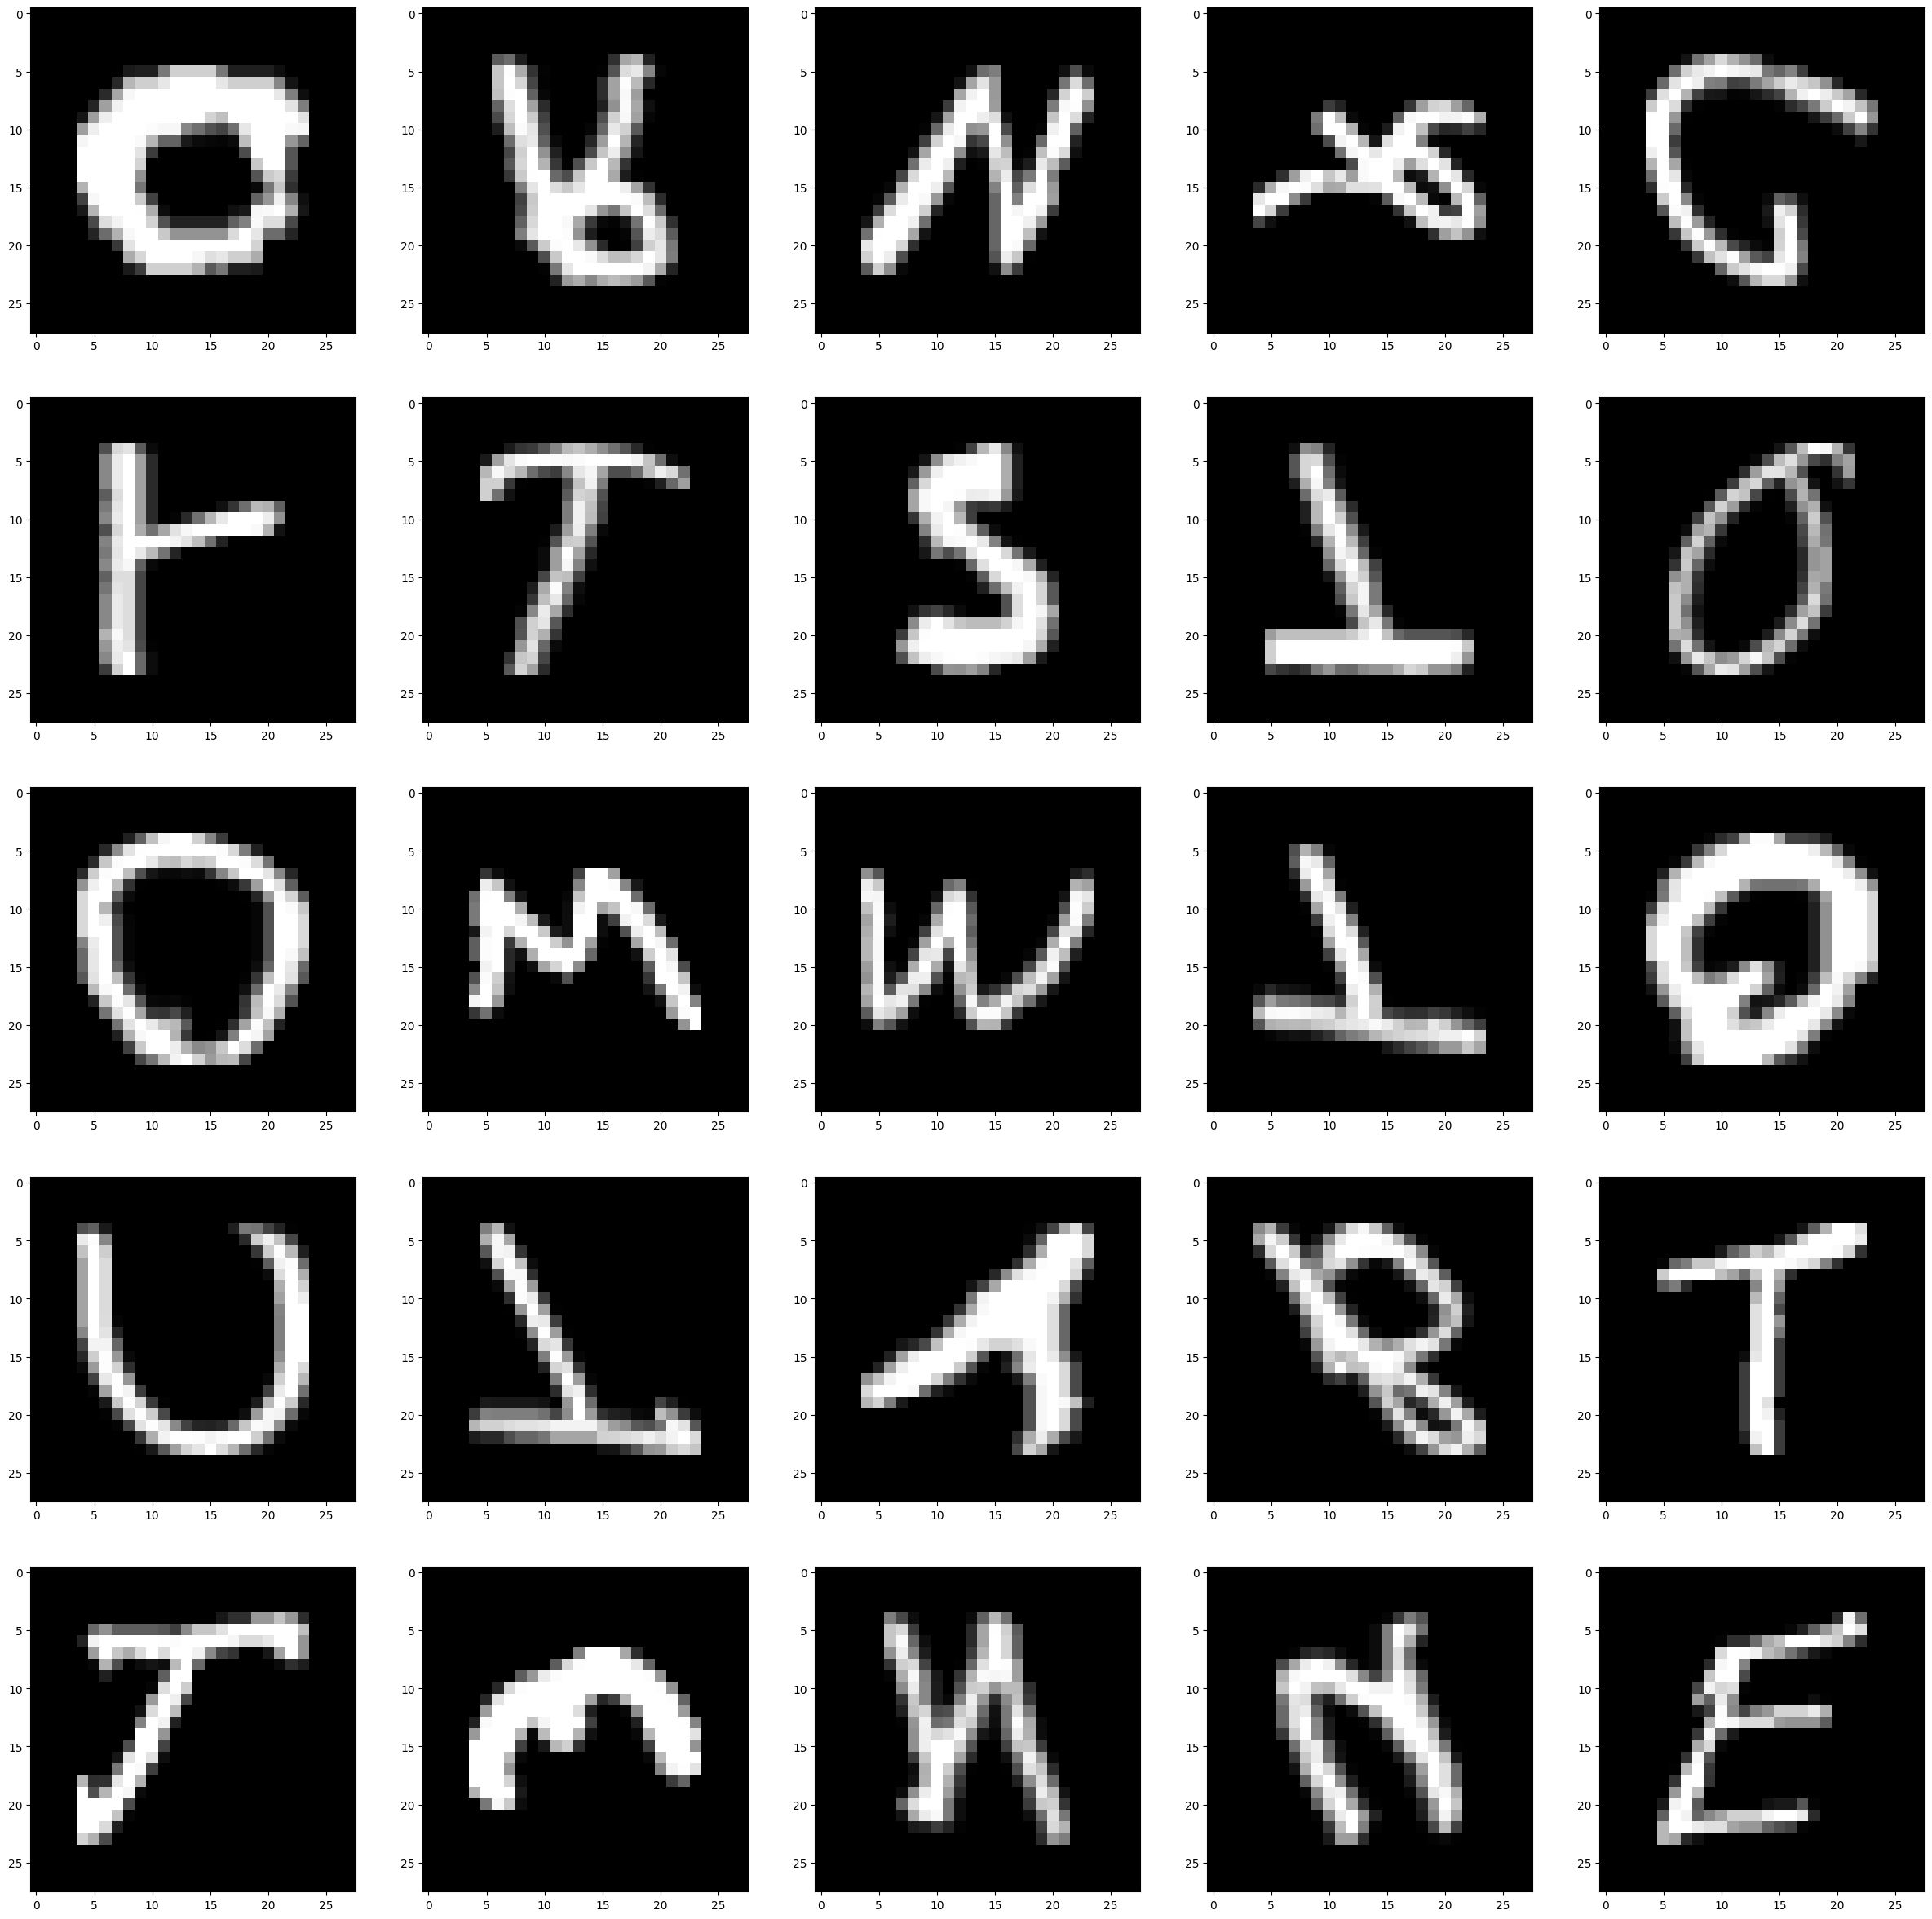

In [83]:
plt.figure(figsize=(30, 30))

for i, (img, lbl) in enumerate(train_set[:25]):
    plt.subplot(5,5,i+1), plt.imshow(img[0].detach().cpu().numpy()*256, cmap = 'gray')

plt.show()

Now, let's rebuild our CNN model from Part 1 and try it again on our new, changed dataset

In [84]:
model = CNN().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr = 2e-3) 
criterion = nn.CrossEntropyLoss()

In [85]:
train_dataloader = DataLoader(dataset = train_set, batch_size = 64, shuffle = True, num_workers = 2)
val_dataloader = DataLoader(dataset = val_set, batch_size = 64, num_workers = 2)

In [87]:
epochs = 5

for i in range(epochs):
    model.train()
    for img, lbl in tqdm(train_dataloader):
        optimizer.zero_grad()
        outputs = model(img.to(DEVICE))

        loss = criterion(outputs, lbl.to(DEVICE))

        loss.backward()
        optimizer.step()
        
    model.eval()
    accuracy = 0
    for img, lbl in val_dataloader:
        lbl = lbl.detach().cpu().numpy().argmax(-1)
        lbl -= model(img.to(DEVICE)).detach().cpu().numpy().argmax(-1)
        
        accuracy += np.count_nonzero(lbl == 0)
                
    print('epoch:', i+1, '\t', f'{accuracy}/{len(val_set)}', '\t', accuracy/len(val_set))

  0%|          | 0/3492 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 3492/3492 [00:19<00:00, 180.08it/s]


epoch: 1 	 52978/74491 	 0.7112000107395524


100%|██████████| 3492/3492 [00:19<00:00, 181.02it/s]


epoch: 2 	 55189/74491 	 0.7408814487656227


100%|██████████| 3492/3492 [00:18<00:00, 184.28it/s]


epoch: 3 	 57423/74491 	 0.770871648924031


100%|██████████| 3492/3492 [00:18<00:00, 190.15it/s]


epoch: 4 	 57623/74491 	 0.7735565370313192


100%|██████████| 3492/3492 [00:18<00:00, 185.18it/s]


epoch: 5 	 59490/74491 	 0.7986199675128539


In [88]:
model.eval()
accuracy = 0
for img, lbl in test_dataloader:
    lbl = lbl.detach().cpu().numpy().argmax(-1)
    lbl -= model(img.to(DEVICE)).detach().cpu().numpy().argmax(-1)

    accuracy += np.count_nonzero(lbl == 0)

print(f'{accuracy}/{len(test_set)}', '\t', accuracy/len(test_set))

59369/74500 	 0.7968993288590605


In [89]:
del model
torch.cuda.empty_cache()   #delete data we don't need
gc.collect()

157271

Understandably, our model performed much less effectively after we flipped and switched around the images a little. It performed with around 80% less effectively, a far cry from our original 90%+. This shows how important the data we feed our models truly are. 

# **TASK 2**

**Part 1**

Let us implement a convolutional variational autoencoder. The basic encoder structure will be a two convolutional layers that squeeze our 28 by 28 data into a 7 by 7 with 64 other layers. Then, we flatten that data and feed it into a linear layer to make it into two sets of BATCH_SIZE by 2 matrices. Our decoder will do the exact opposite, taking BATCH_SIZE by 2 matrices and spitting out a 28 by 28 data matrix.

In [90]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class CVAE(nn.Module):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim 
        self.encoder = nn.Sequential(*[                                            #input size =  [64, 1, 28, 28]
            nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1),            #output size = [64, 32, 14, 14]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1),           #output size = [64, 64, 7, 7]
            nn.Flatten(-3),                                                        #output size = [64, 64*7*7]
            nn.Linear(64*7*7, latent_dim*2)                                        #output size = [64, latent_dim*2]
        ])
        
        self.decoder = nn.Sequential(*[
            nn.Linear(latent_dim, 64*7*7),                                         #output size = [latent_dim, 64*7*7]
            Reshape(-1, 64, 7, 7),
            nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2, padding = 0),  #output size = [64, 32, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size = 2, stride = 2, padding = 0),   #output size = [64, 32, 28, 28]
            nn.Sigmoid()
        ])

    def sample(self, eps=None):
        if eps is None:
            eps = torch.randn((100, self.latent_dim))
        return self.decode(eps)

    def encode(self, x):
        mean, logvar = torch.chunk(self.encoder(x), 2, dim=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = torch.randn(mean.shape).to(DEVICE)
        return eps * logvar + mean

    def decode(self, z):
        logits = self.decoder(z)
        return logits

In [91]:
epochs = 3
latent_dim = 2
vae = CVAE(latent_dim).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), 1e-3)

In [92]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [93]:
def generate_images(model, epoch, test_sample):
    mean, logvar = vae.encode(test_sample)
    z = vae.reparameterize(mean, logvar)
    predictions = vae.sample(z)
    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(1, 6, i + 1)
        plt.imshow(predictions[i, 0, :, :].detach().cpu().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()

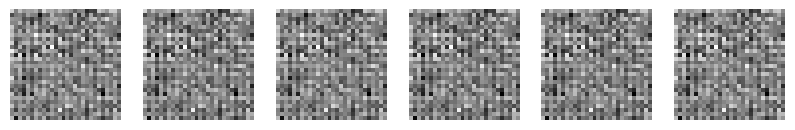

In [94]:
test_sample = torch.Tensor()
for i in range(6):
    test_sample = torch.cat((test_sample, train_set[i][0].unsqueeze(0)), dim = 0)
generate_images(vae, 1, test_sample.to(DEVICE))

In [95]:
train_dataloader = DataLoader(dataset = train_set[:int(len(train_set))], batch_size = 64, num_workers = 1)
test_dataloader = DataLoader(dataset = test_set[:int(len(test_set))], batch_size = 64, num_workers = 1)

100%|██████████| 1165/1165 [00:04<00:00, 234.48it/s]


Epoch: 1, Test set ELBO: -14728960.0


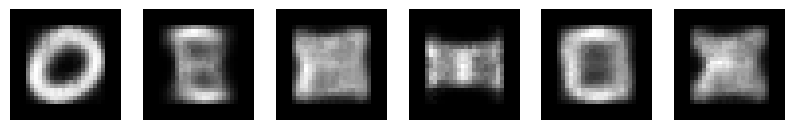

100%|██████████| 1165/1165 [00:04<00:00, 244.60it/s]


Epoch: 2, Test set ELBO: -14595221.0


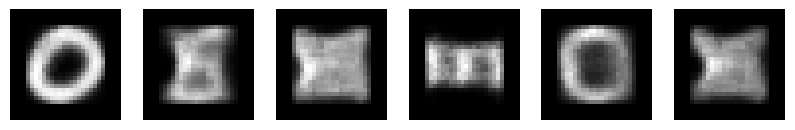

100%|██████████| 1165/1165 [00:04<00:00, 236.30it/s]


Epoch: 3, Test set ELBO: -14498961.0


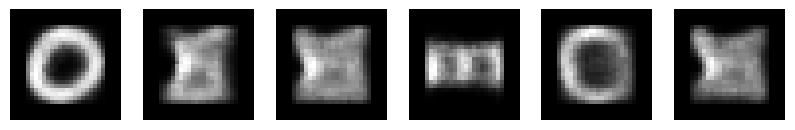

In [96]:
for epoch in range(1, epochs + 1):
    for train_x, lbl in tqdm(train_dataloader):
        optimizer.zero_grad()
        mean, logvar = vae.encode(train_x.to(DEVICE))
        z = vae.reparameterize(mean, logvar)
        output = vae.decode(z)
        loss = loss_function(train_x.to(DEVICE), output, mean, logvar)
        
        loss.backward()
        optimizer.step()
    del train_x, mean, logvar, z, output
    torch.cuda.empty_cache()
    gc.collect()
        
#         break
#     break

    losses = 0
    for test_x, lbl in tqdm(test_dataloader):
        mean, logvar = vae.encode(test_x.to(DEVICE))
        z = vae.reparameterize(mean, logvar)
        output = vae.decode(z)
        loss = loss_function(test_x.to(DEVICE), output, mean, logvar)
        
        losses += loss
        
    del test_x, mean, logvar, z, output
    torch.cuda.empty_cache()
    gc.collect()
    
    elbo = -torch.mean(losses)
    print('Epoch: {}, Test set ELBO: {}'.format(epoch, elbo))
    generate_images(vae, epoch, test_sample.to(DEVICE))

As we can see, our data is much blurrier than it was before but it is still somewhat recognizable.